In [3]:
# Import necessary libraries
import praw
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import json
from collections import Counter
from datetime import datetime, timedelta
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import networkx as nx
import community as community_louvain
import time

In [5]:
# Download required NLTK resources
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\prana\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
# Initialize Reddit client
from redditClient import redditClient
reddit = redditClient()

In [9]:
#2. Data Collection

# Define subreddits and keywords for train discussions
subreddits = ["MelbourneTrains", "VlineVictoria"]
keywords = ["VLine", "VLine train", "Metro", "Metro Melbourne", "Metro Trains"]

In [11]:
def is_relevant(text, keywords):
    """Check if text contains any of the specified keywords (case-insensitive)"""
    if not isinstance(text, str):
        return False
    text_lower = text.lower()
    return any(keyword.lower() in text_lower for keyword in keywords)

In [13]:
def fetch_reddit_posts(subreddits, query_terms, limit=1000):
    """Fetch posts from specified subreddits containing query terms"""
    posts = []
    for subreddit_name in subreddits:
        subreddit = reddit.subreddit(subreddit_name)
        # Search posts matching any of the query terms in title or selftext
        for submission in subreddit.search(" OR ".join(query_terms), limit=limit):
            posts.append({
                'id': submission.id,
                'title': submission.title,
                'text': submission.selftext,
                'author': str(submission.author),
                'created_utc': submission.created_utc,
                'subreddit': subreddit_name,
                'url': submission.url,
                'score': submission.score
            })
    return pd.DataFrame(posts)

In [15]:
def collect_posts(subreddits, keywords):
    """Collect relevant posts from specified subreddits"""
    posts_data = []
    
    for subreddit_name in subreddits:
        print(f"Collecting from r/{subreddit_name}...")
        subreddit = reddit.subreddit(subreddit_name)
        
        # Get top posts from all time
        for submission in subreddit.top(time_filter="all", limit=None):
            if submission.stickied:
                continue  # Skip announcements
            
            # Check title or text for keywords
            if is_relevant(submission.title, keywords) or is_relevant(submission.selftext, keywords):
                posts_data.append({
                    'id': submission.id,
                    'title': submission.title,
                    'text': submission.selftext,
                    'score': submission.score,
                    'created_utc': datetime.fromtimestamp(submission.created_utc),
                    'author': str(submission.author),
                    'url': submission.url,
                    'subreddit': subreddit_name
                })
        print(f"Found {len(posts_data)} posts so far...")
    
    return pd.DataFrame(posts_data)

In [17]:
def collect_comments(posts_df, keywords):
    """Collect comments from posts that contain relevant keywords"""
    comments_data = []
    
    for i, post_id in enumerate(posts_df['id']):
        try:
            submission = reddit.submission(id=post_id)
            submission.comments.replace_more(limit=0)
            
            for comment in submission.comments.list():
                if is_relevant(comment.body, keywords):
                    comments_data.append({
                        'text': comment.body,
                        'score': comment.score,
                        'created_utc': datetime.fromtimestamp(comment.created_utc),
                        'author': str(comment.author),
                        'post_id': post_id
                    })
            
            if i % 10 == 0:
                print(f"Processed {i+1}/{len(posts_df)} posts ({len(comments_data)} comments)")
                
        except Exception as e:
            print(f"Error processing post {post_id}: {e}")
    
    return pd.DataFrame(comments_data)

In [19]:
# Collect and save post data
posts_df = collect_posts(subreddits, keywords)
print(f"Total collected posts: {len(posts_df)}")
posts_df.to_csv('melbourne_trains_data.csv', index=False)

Found 111 posts so far...
Found 211 posts so far...
Total collected posts: 211


In [20]:
# Collect and save comment data
comments_df = collect_comments(posts_df, keywords)
comments_df.to_csv('trains_comments_data.csv', index=False)

Processed 1/211 posts (2 comments)
Processed 11/211 posts (85 comments)
Processed 21/211 posts (129 comments)
Processed 31/211 posts (183 comments)
Processed 41/211 posts (220 comments)
Processed 51/211 posts (322 comments)
Processed 61/211 posts (354 comments)
Processed 71/211 posts (394 comments)
Processed 81/211 posts (432 comments)
Processed 91/211 posts (471 comments)
Processed 101/211 posts (492 comments)
Processed 111/211 posts (534 comments)
Processed 121/211 posts (556 comments)
Processed 131/211 posts (594 comments)
Processed 141/211 posts (619 comments)
Processed 151/211 posts (637 comments)
Processed 161/211 posts (673 comments)
Processed 171/211 posts (710 comments)
Processed 181/211 posts (734 comments)
Processed 191/211 posts (756 comments)
Processed 201/211 posts (766 comments)
Processed 211/211 posts (787 comments)


In [21]:
# 3.Text Preprocessing and Sentiment Analysis

# Initialize NLP tools
tokenizer = word_tokenize
stemmer = PorterStemmer()

In [22]:
# Custom stopwords setup
base_stopwords = set(stopwords.words('english'))

In [24]:
# Transport-related keywords to keep
transport_keywords = {
    'vline', 'metro', 'train', 'trains', 'rail', 'service', 
    'services', 'station', 'stations', 'melbourne', 'public',
    'transport', 'prefer', 'preferred', 'like', 'better'
}

In [25]:
# Remove transport keywords from stopwords
custom_stopwords = [word for word in base_stopwords if word not in transport_keywords]

In [27]:
# Add common irrelevant words
extra_stopwords = {
    'would', 'could', 'also', 'get', 'go', 'even',
    'say', 'one', 'two', 'us', 'much', 'many'
}

final_stopwords = set(custom_stopwords).union(extra_stopwords)

In [35]:
def clean_text(text):
    """Clean and preprocess text by:
    - Converting to lowercase
    - Removing URLs
    - Removing punctuation
    - Normalizing whitespace
    """
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-z0-9\s]", "", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Normalize whitespace
    return text

In [37]:
# Apply text cleaning to both posts and comments
posts_df['clean_text'] = posts_df['text'].fillna('').apply(clean_text)
comments_df['clean_text'] = comments_df['text'].fillna('').apply(clean_text)

In [39]:
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [43]:
# Compute sentiment compound scores for both datasets
posts_df['sentiment'] = posts_df['clean_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
comments_df['sentiment'] = comments_df['clean_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
def sentiment_label(score):
    """Categorize sentiment score into positive, negative or neutral"""
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [45]:
# Apply sentiment labels to both datasets
posts_df['sentiment_label'] = posts_df['sentiment'].apply(sentiment_label)
comments_df['sentiment_label'] = comments_df['sentiment'].apply(sentiment_label)

In [47]:
# Save data with sentiment
posts_df.to_csv('melbourne_trains_data_sentiment.csv', index=False)
comments_df.to_csv('trains_comments_data_sentiment.csv', index=False)

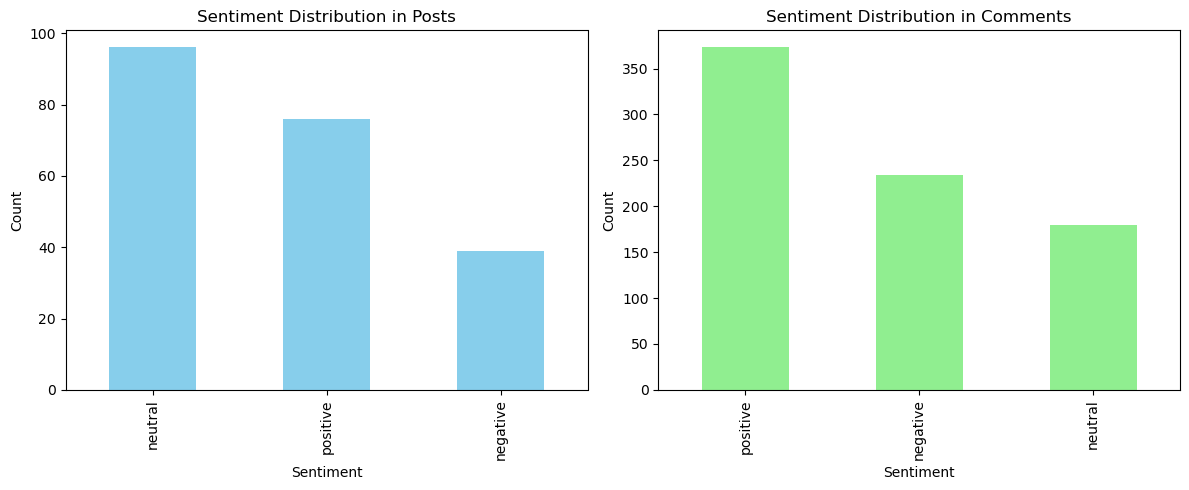

In [53]:
# Compare sentiment distribution between posts and comments
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
posts_df['sentiment_label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Sentiment Distribution in Posts')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
comments_df['sentiment_label'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Sentiment Distribution in Comments')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [55]:
# Print summary statistics
print("Posts Sentiment Summary:")
print(posts_df['sentiment'].describe())
print("\nComments Sentiment Summary:")
print(comments_df['sentiment'].describe())


Posts Sentiment Summary:
count    211.000000
mean       0.130516
std        0.472306
min       -0.936300
25%        0.000000
50%        0.000000
75%        0.493300
max        0.995400
Name: sentiment, dtype: float64

Comments Sentiment Summary:
count    787.000000
mean       0.131990
std        0.498622
min       -0.976200
25%       -0.203000
50%        0.000000
75%        0.526700
max        0.995500
Name: sentiment, dtype: float64


In [57]:
# Compare average sentiment
print(f"\nAverage sentiment in posts: {posts_df['sentiment'].mean():.3f}")
print(f"Average sentiment in comments: {comments_df['sentiment'].mean():.3f}")



Average sentiment in posts: 0.131
Average sentiment in comments: 0.132


In [61]:
# Additional analysis: Most positive/negative comments
most_positive_comment = comments_df.loc[comments_df['sentiment'].idxmax()]
most_negative_comment = comments_df.loc[comments_df['sentiment'].idxmin()]

print("\nMost Positive Comment:")
print(f"Score: {most_positive_comment['score']}, Sentiment: {most_positive_comment['sentiment']:.3f}")
print(most_positive_comment['text'][:200] + "...")

print("\nMost Negative Comment:")
print(f"Score: {most_negative_comment['score']}, Sentiment: {most_negative_comment['sentiment']:.3f}")
print(most_negative_comment['text'][:200] + "...")


Most Positive Comment:
Score: 14, Sentiment: 0.996
Few things;
- Shouldn’t Metro be the thinner lines? They stop more often and are shorter.
- Why is Ballarat counted as a regional city zone but not Bendigo despite it being bigger?
- Shouldn’t all the...

Most Negative Comment:
Score: 1, Sentiment: -0.976
You’re taking everything way too personally like I am personally attacking you. I don’t know you and I don’t care to. Answer this one question, if you got on a train and something catastrophic happene...


In [63]:
# Word frequency analysis for both datasets
def get_word_frequencies(text_series, top_n=20):
    all_words = ' '.join(text_series).split()
    freq_dist = FreqDist(all_words)
    return freq_dist.most_common(top_n)

post_word_freq = get_word_frequencies(posts_df['clean_text'])
comment_word_freq = get_word_frequencies(comments_df['clean_text'])

print("\nTop words in posts:")
for word, freq in post_word_freq:
    print(f"{word}: {freq}")

print("\nTop words in comments:")
for word, freq in comment_word_freq:
    print(f"{word}: {freq}")


Top words in posts:
the: 524
to: 356
a: 252
and: 246
i: 204
of: 176
on: 138
in: 124
is: 123
this: 110
for: 108
train: 104
it: 100
vline: 98
from: 84
line: 84
at: 81
that: 75
you: 73
with: 72

Top words in comments:
the: 2598
to: 1579
a: 1304
and: 1203
of: 838
is: 775
metro: 671
it: 620
in: 599
you: 572
i: 557
that: 509
for: 507
have: 432
are: 417
on: 414
be: 414
not: 403
this: 392
vline: 368


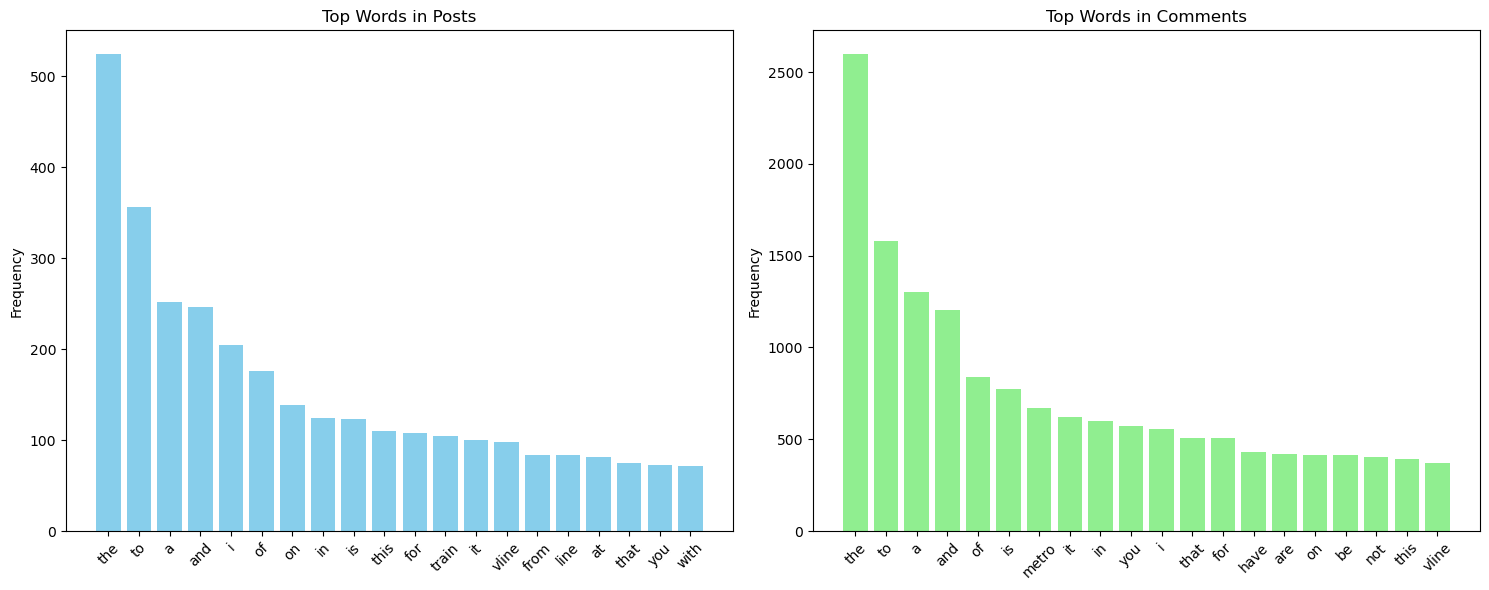

In [65]:
# Visualization of word frequencies
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
words, freqs = zip(*post_word_freq)
plt.bar(words, freqs, color='skyblue')
plt.title('Top Words in Posts')
plt.xticks(rotation=45)
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
words, freqs = zip(*comment_word_freq)
plt.bar(words, freqs, color='lightgreen')
plt.title('Top Words in Comments')
plt.xticks(rotation=45)
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [67]:
# 4. Network Analysis 

def fetch_replies_with_retry(submission_id, max_retries=3):
    """Fetch comment replies with retry logic for rate limiting"""
    retries = 0
    while retries < max_retries:
        try:
            submission = reddit.submission(id=submission_id)
            submission.comments.replace_more(limit=5)  # Limit "more comments" expansions
            edges = []
            comment_data = []
            
            for comment in submission.comments.list()[:200]:  # Increased limit for better network
                # Add to network edges
                if comment.author and comment.parent_id.startswith('t1_'):
                    parent = reddit.comment(id=comment.parent_id[3:])
                    if parent.author:
                        edges.append((str(comment.author), str(parent.author)))
                
                # Collect comment metadata for analysis
                comment_data.append({
                    'id': comment.id,
                    'author': str(comment.author),
                    'score': comment.score,
                    'depth': comment.depth,
                    'created_utc': comment.created_utc,
                    'post_id': submission_id
                })
            
            return edges, comment_data
            
        except Exception as e:
            if '429' in str(e):
                wait = (2 ** retries) * 5
                print(f"Rate limited. Waiting {wait} seconds...")
                time.sleep(wait)
                retries += 1
            else:
                print(f"Error fetching replies for {submission_id}: {e}")
                return [], []
    print(f"Failed to fetch replies after {max_retries} retries for {submission_id}")
    return [], []


In [69]:
# Build interaction graph with enhanced comment data
edges = []
comment_network_data = []

for i, post_id in enumerate(posts_df['id'].head(50)):  # Analyze top 50 posts
    post_edges, post_comments = fetch_replies_with_retry(post_id)
    edges += post_edges
    comment_network_data.extend(post_comments)
    time.sleep(1)  # Reduced delay for efficiency
    if (i+1) % 5 == 0:
        print(f"Processed {i+1} posts, collected {len(comment_network_data)} comments")

Rate limited. Waiting 5 seconds...
Processed 5 posts, collected 605 comments
Processed 10 posts, collected 857 comments
Processed 15 posts, collected 1045 comments
Processed 20 posts, collected 1302 comments
Rate limited. Waiting 5 seconds...
Processed 25 posts, collected 1561 comments
Processed 30 posts, collected 1866 comments
Processed 35 posts, collected 2088 comments
Processed 40 posts, collected 2339 comments
Processed 45 posts, collected 2687 comments
Processed 50 posts, collected 2939 comments


In [71]:
# Create dataframes for network analysis
comment_network_df = pd.DataFrame(comment_network_data)
comment_network_df['created_dt'] = pd.to_datetime(comment_network_df['created_utc'], unit='s')

In [73]:
# Create directed graph with edge weights
G = nx.DiGraph()
for edge in edges:
    if G.has_edge(*edge):
        G.edges[edge]['weight'] += 1  # Increment weight for repeated interactions
    else:
        G.add_edge(*edge, weight=1)

print(f"Graph nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")

def enhanced_analyze_graph(G, comment_df):
    """Enhanced graph analysis with comment metrics"""
    print(f"Number of nodes (users): {G.number_of_nodes()}")
    print(f"Number of edges (interactions): {G.number_of_edges()}")
    
    # Basic graph metrics
    clustering = nx.transitivity(G.to_undirected())
    density = nx.density(G)
    print(f"Global clustering coefficient: {clustering:.4f}")
    print(f"Network density: {density:.6f}")
    
    # Community detection with Louvain
    undirected_graph = G.to_undirected()
    partition = community_louvain.best_partition(undirected_graph)
    print(f"Number of communities detected: {len(set(partition.values()))}")
    
    # Add comment metrics to analysis
    if not comment_df.empty:
        # Temporal analysis
        comment_df['hour'] = comment_df['created_dt'].dt.hour
        hourly_activity = comment_df.groupby('hour').size()
        
        # Engagement metrics
        avg_comment_depth = comment_df['depth'].mean()
        avg_comment_score = comment_df['score'].mean()
        print(f"\nComment Engagement Metrics:")
        print(f"Average comment depth: {avg_comment_depth:.1f}")
        print(f"Average comment score: {avg_comment_score:.1f}")
        
        # Visualizations
        plt.figure(figsize=(15, 10))
        
        # Hourly activity
        plt.subplot(2, 2, 1)
        hourly_activity.plot(kind='bar', color='teal')
        plt.title('Comment Activity by Hour of Day')
        plt.xlabel('Hour')
        plt.ylabel('Number of Comments')
        
        # Comment depth distribution
        plt.subplot(2, 2, 2)
        comment_df['depth'].value_counts().sort_index().plot(kind='bar', color='purple')
        plt.title('Comment Depth Distribution')
        plt.xlabel('Depth in Thread')
        plt.ylabel('Number of Comments')
        
        # Community size distribution
        plt.subplot(2, 2, 3)
        pd.Series(partition).value_counts().plot(kind='bar', color='orange')
        plt.title('Community Size Distribution')
        plt.xlabel('Community ID')
        plt.ylabel('Number of Users')
        
        # Comment score distribution
        plt.subplot(2, 2, 4)
        comment_df['score'].plot(kind='hist', bins=30, color='green', alpha=0.7)
        plt.title('Distribution of Comment Scores')
        plt.xlabel('Score')
        plt.ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
    
    # Centrality measures
    deg_cent = nx.degree_centrality(G)
    between_cent = nx.betweenness_centrality(G)
    eig_cent = nx.eigenvector_centrality_numpy(G)
    
    # Identify key users
    top_degree = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:5]
    top_betweenness = sorted(between_cent.items(), key=lambda x: x[1], reverse=True)[:5]
    
    print("\nTop Users by Degree Centrality:")
    for user, score in top_degree:
        print(f"{user}: {score:.4f}")
    
    print("\nTop Users by Betweenness Centrality:")
    for user, score in top_betweenness:
        print(f"{user}: {score:.4f}")
    
    return deg_cent, between_cent, eig_cent, partition, comment_network_df


Graph nodes: 814, edges: 1343


Number of nodes (users): 814
Number of edges (interactions): 1343
Global clustering coefficient: 0.0305
Network density: 0.002029
Number of communities detected: 71

Comment Engagement Metrics:
Average comment depth: 1.5
Average comment score: 8.9


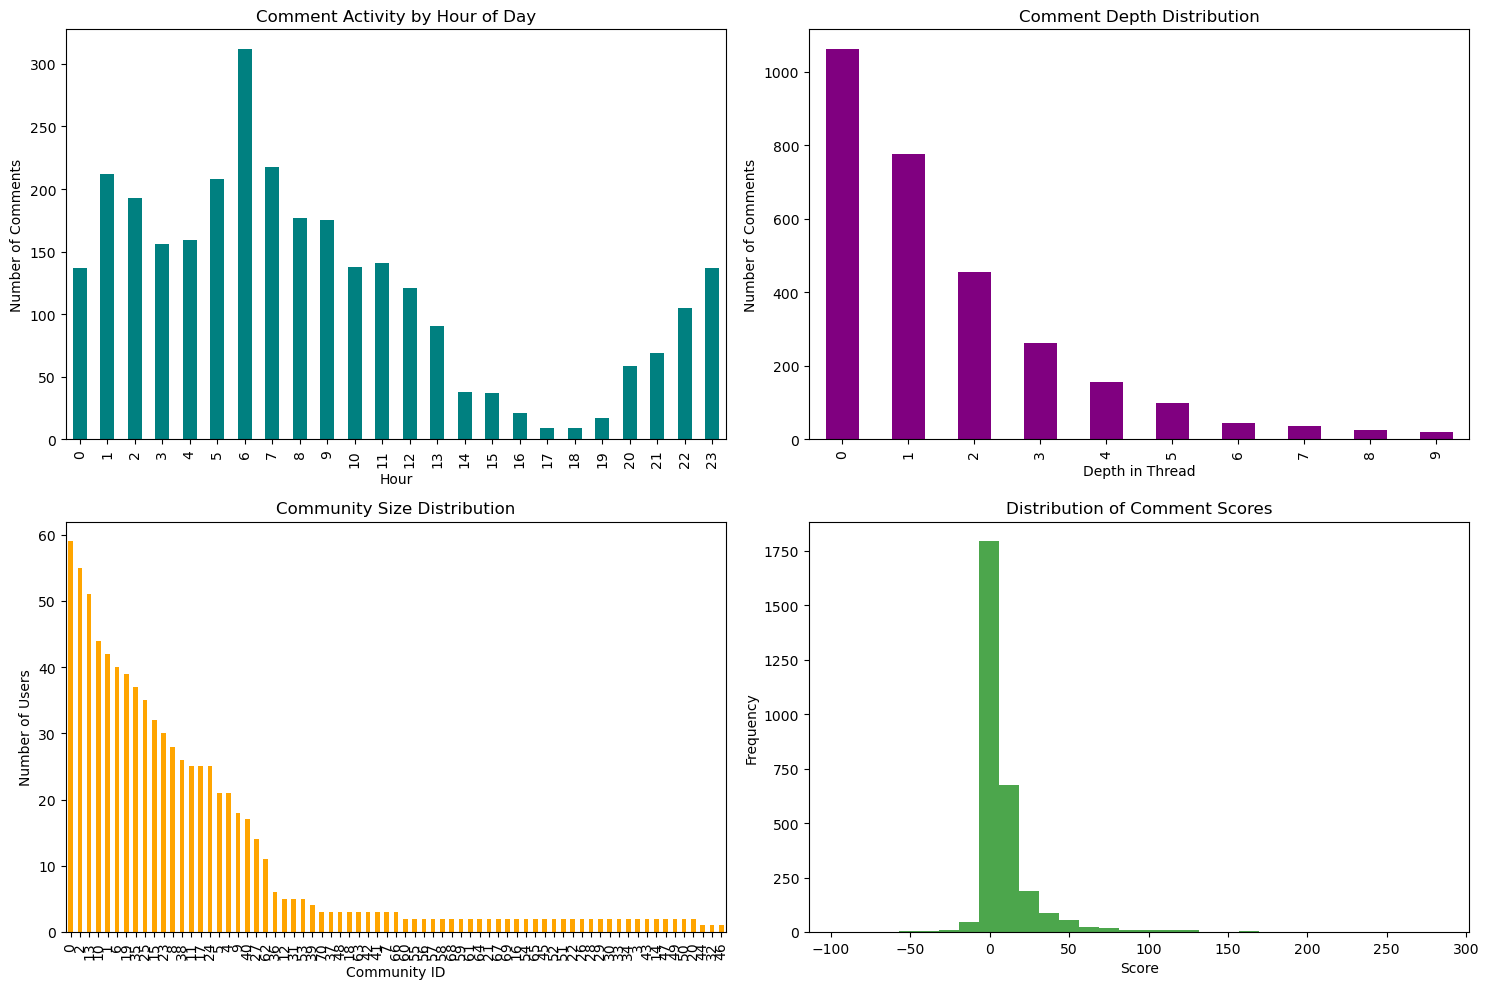


Top Users by Degree Centrality:
Economy_Square_1452: 0.0627
wongm: 0.0431
PolygonTransit: 0.0418
Blue_Pie_Ninja: 0.0381
Johntrampoline-: 0.0381

Top Users by Betweenness Centrality:
Blue_Pie_Ninja: 0.0493
Economy_Square_1452: 0.0469
Ok-Foot6064: 0.0438
wongm: 0.0398
PolygonTransit: 0.0351


In [75]:
# Run enhanced analysis
deg_cent, between_cent, eig_cent, partition, comment_network_df = enhanced_analyze_graph(G, comment_network_df)

In [77]:
# 5. Comparative Analysis of VLine vs Metro (Extended)

def classify_transport(text):
    """Enhanced classification for transport type with comment support"""
    text = text.lower()
    vline_terms = ['vline', 'regional train', 'country train']
    metro_terms = ['metro', 'metro train', 'suburban train']
    
    is_vline = any(term in text for term in vline_terms)
    is_metro = any(term in text for term in metro_terms)
    
    if is_vline and not is_metro:
        return 'vline'
    elif is_metro and not is_vline:
        return 'metro'
    elif is_vline and is_metro:
        return 'both'
    else:
        return 'none'


In [79]:
# Classify both posts and comments
posts_df['transport_type'] = posts_df['clean_text'].apply(classify_transport)
comments_df['transport_type'] = comments_df['clean_text'].apply(classify_transport)

In [81]:
# Filter relevant data
relevant_posts = posts_df[posts_df['transport_type'] != 'none']
relevant_comments = comments_df[comments_df['transport_type'] != 'none']

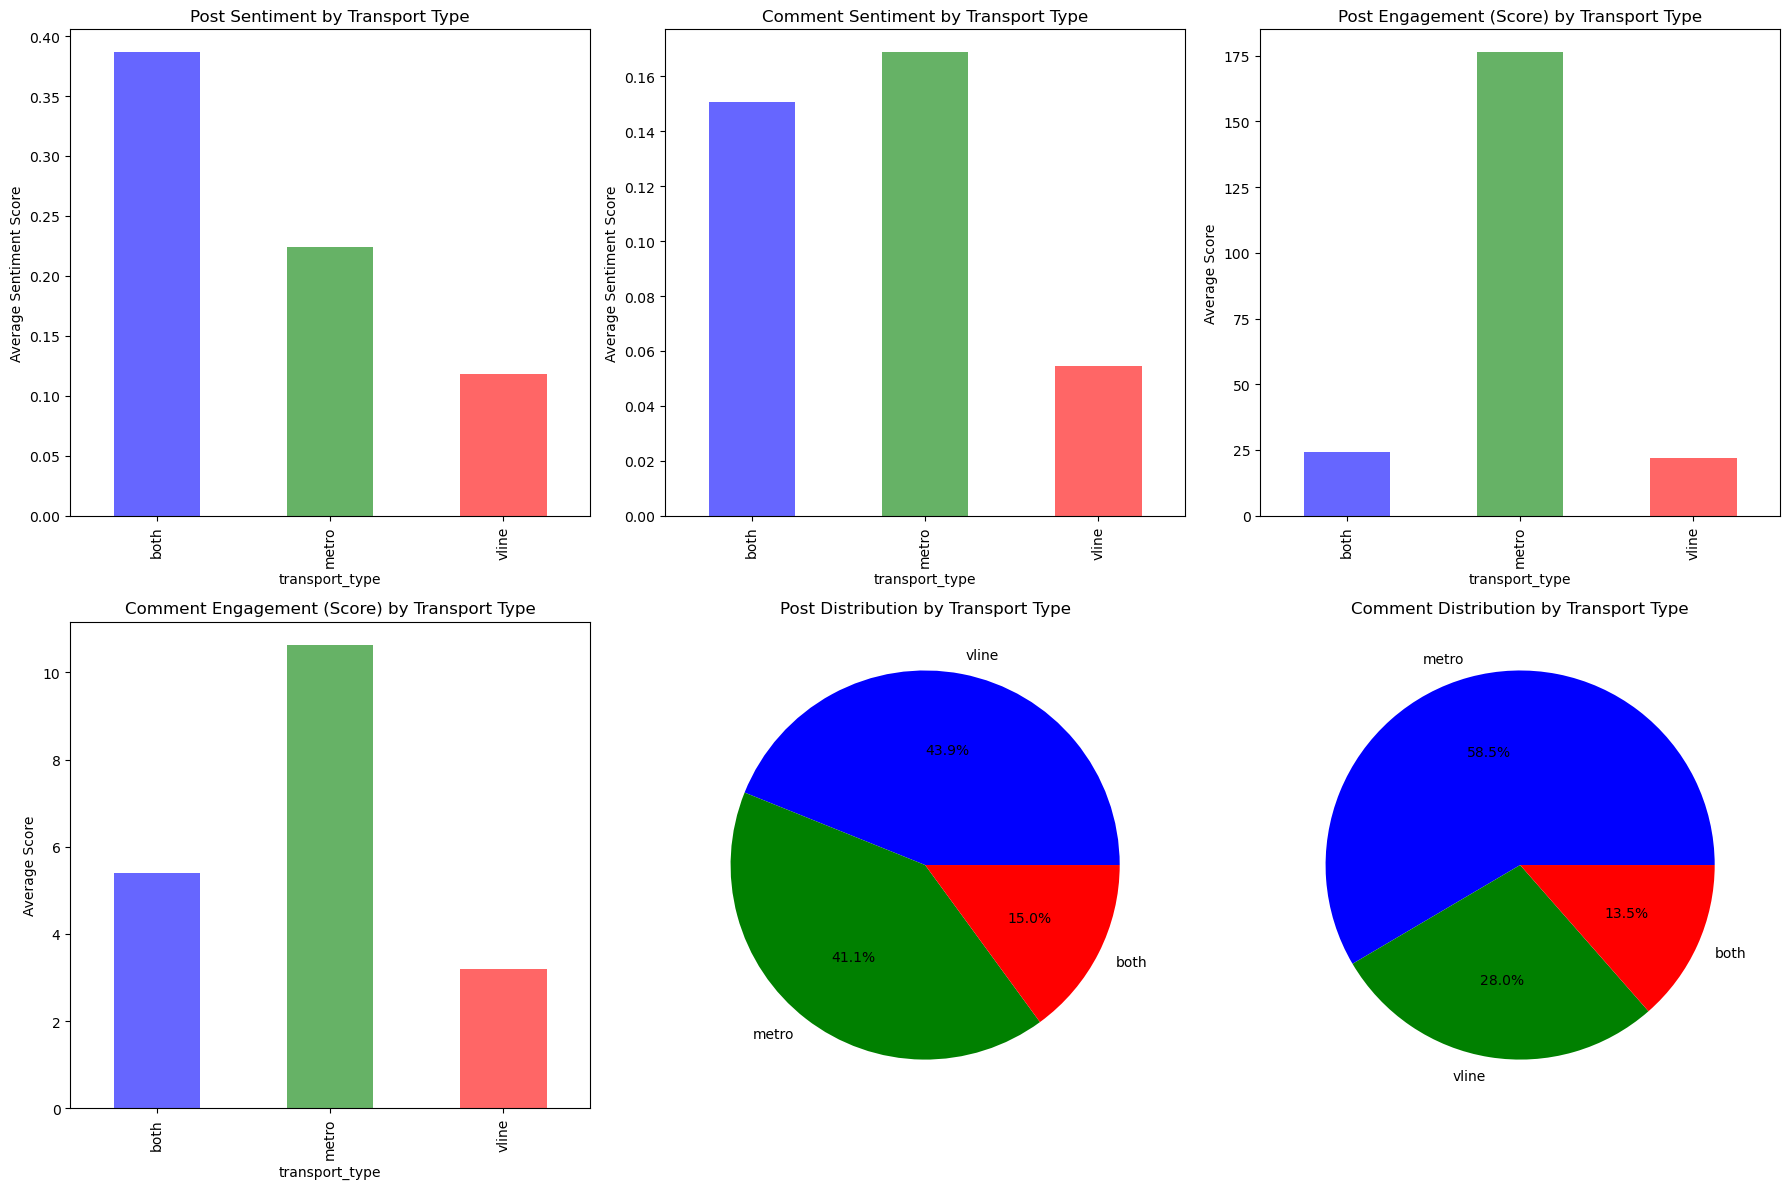

Sentiment Comparison:
Posts - VLine: 0.118, Metro: 0.224
Comments - VLine: 0.055, Metro: 0.169

Engagement Comparison:
Posts - VLine: 22.0, Metro: 176.2
Comments - VLine: 3.2, Metro: 10.6

Volume Comparison:
Posts - VLine: 47, Metro: 44
Comments - VLine: 213, Metro: 445


In [83]:
# Combined analysis function
def analyze_transport_comparison(posts, comments):
    """Comparative analysis across posts and comments"""
    # Sentiment comparison
    post_sentiment = posts.groupby('transport_type')['sentiment'].mean()
    comment_sentiment = comments.groupby('transport_type')['sentiment'].mean()
    
    # Engagement comparison
    post_engagement = posts.groupby('transport_type')['score'].mean()
    comment_engagement = comments.groupby('transport_type')['score'].mean()
    
    # Volume comparison
    post_counts = posts['transport_type'].value_counts()
    comment_counts = comments['transport_type'].value_counts()
    
    # Visualization
    plt.figure(figsize=(18, 12))
    
    # Sentiment comparison
    plt.subplot(2, 3, 1)
    post_sentiment.plot(kind='bar', color=['blue', 'green', 'red'], alpha=0.6)
    plt.title('Post Sentiment by Transport Type')
    plt.ylabel('Average Sentiment Score')
    
    plt.subplot(2, 3, 2)
    comment_sentiment.plot(kind='bar', color=['blue', 'green', 'red'], alpha=0.6)
    plt.title('Comment Sentiment by Transport Type')
    plt.ylabel('Average Sentiment Score')
    
    # Engagement comparison
    plt.subplot(2, 3, 3)
    post_engagement.plot(kind='bar', color=['blue', 'green', 'red'], alpha=0.6)
    plt.title('Post Engagement (Score) by Transport Type')
    plt.ylabel('Average Score')
    
    plt.subplot(2, 3, 4)
    comment_engagement.plot(kind='bar', color=['blue', 'green', 'red'], alpha=0.6)
    plt.title('Comment Engagement (Score) by Transport Type')
    plt.ylabel('Average Score')
    
    # Volume comparison
    plt.subplot(2, 3, 5)
    post_counts.plot(kind='pie', autopct='%1.1f%%', colors=['blue', 'green', 'red'])
    plt.title('Post Distribution by Transport Type')
    plt.ylabel('')
    
    plt.subplot(2, 3, 6)
    comment_counts.plot(kind='pie', autopct='%1.1f%%', colors=['blue', 'green', 'red'])
    plt.title('Comment Distribution by Transport Type')
    plt.ylabel('')
    
    plt.tight_layout()
    plt.show()
    
    # Print key metrics
    print("Sentiment Comparison:")
    print(f"Posts - VLine: {post_sentiment.get('vline', 0):.3f}, Metro: {post_sentiment.get('metro', 0):.3f}")
    print(f"Comments - VLine: {comment_sentiment.get('vline', 0):.3f}, Metro: {comment_sentiment.get('metro', 0):.3f}")
    
    print("\nEngagement Comparison:")
    print(f"Posts - VLine: {post_engagement.get('vline', 0):.1f}, Metro: {post_engagement.get('metro', 0):.1f}")
    print(f"Comments - VLine: {comment_engagement.get('vline', 0):.1f}, Metro: {comment_engagement.get('metro', 0):.1f}")
    
    print("\nVolume Comparison:")
    print(f"Posts - VLine: {post_counts.get('vline', 0)}, Metro: {post_counts.get('metro', 0)}")
    print(f"Comments - VLine: {comment_counts.get('vline', 0)}, Metro: {comment_counts.get('metro', 0)}")

# Run comparative analysis
analyze_transport_comparison(relevant_posts, relevant_comments)

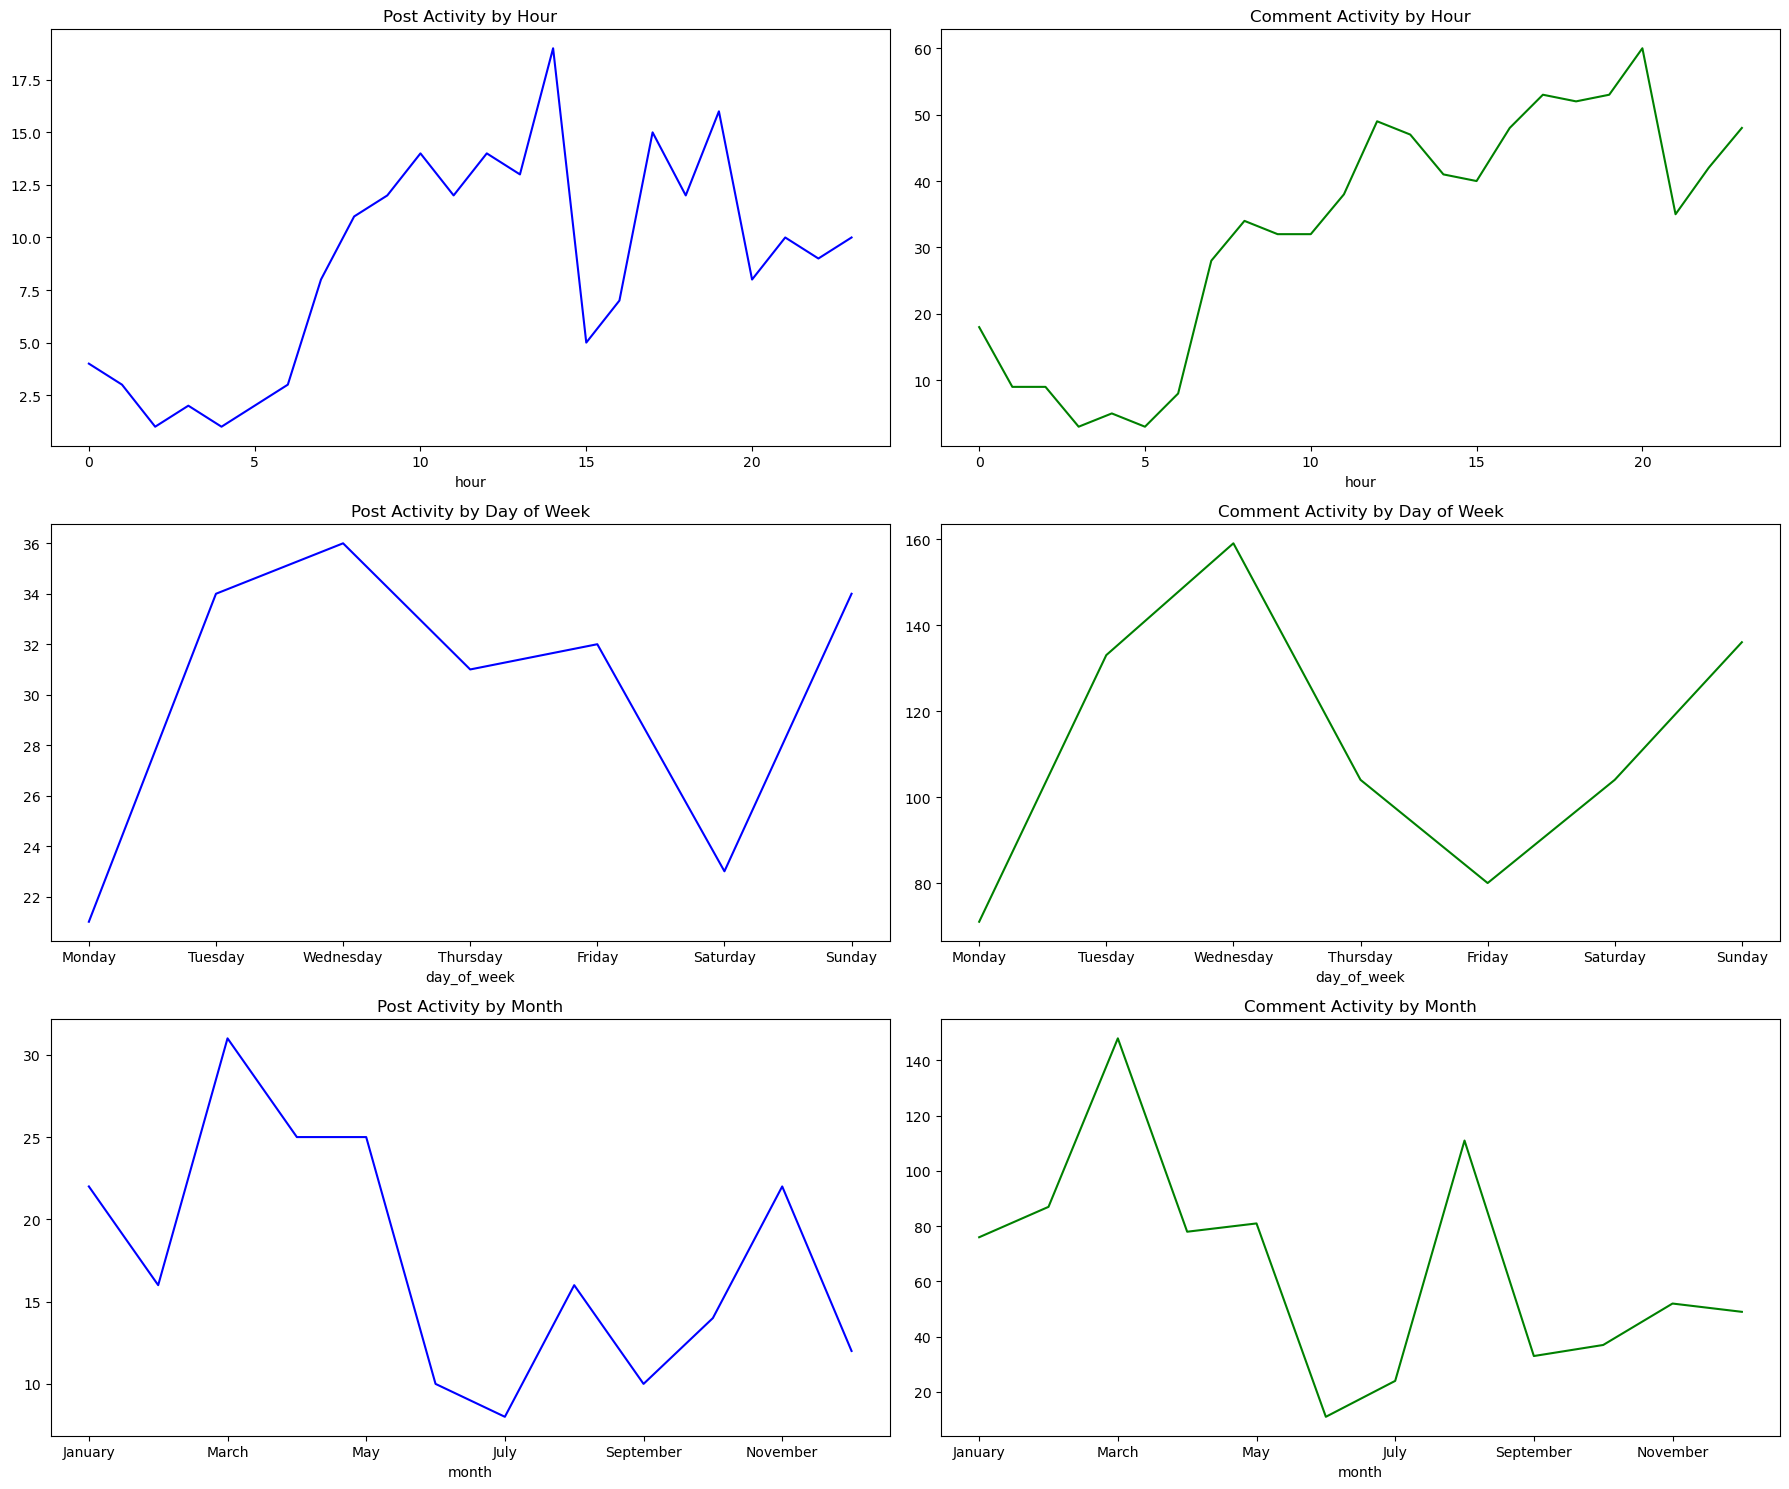


Engagement by Hour:
Posts - Peak engagement hour: 4
Comments - Peak engagement hour: 6


In [84]:
# 6. Temporal and Network Analysis (Extended)

def analyze_temporal_patterns(posts, comments):
    """Analyze temporal patterns across posts and comments"""
    # Convert to datetime if needed
    if not pd.api.types.is_datetime64_any_dtype(posts['created_utc']):
        posts['created_dt'] = pd.to_datetime(posts['created_utc'], unit='s')
    else:
        posts['created_dt'] = posts['created_utc']
    
    if not pd.api.types.is_datetime64_any_dtype(comments['created_utc']):
        comments['created_dt'] = pd.to_datetime(comments['created_utc'], unit='s')
    else:
        comments['created_dt'] = comments['created_utc']
    
    # Extract temporal features
    posts['hour'] = posts['created_dt'].dt.hour
    posts['day_of_week'] = posts['created_dt'].dt.day_name()
    posts['month'] = posts['created_dt'].dt.month_name()
    
    comments['hour'] = comments['created_dt'].dt.hour
    comments['day_of_week'] = comments['created_dt'].dt.day_name()
    comments['month'] = comments['created_dt'].dt.month_name()
    
    # Prepare visualizations
    fig, axes = plt.subplots(3, 2, figsize=(18, 15))
    
    # Hourly patterns
    posts.groupby('hour').size().plot(ax=axes[0,0], title='Post Activity by Hour', color='blue')
    comments.groupby('hour').size().plot(ax=axes[0,1], title='Comment Activity by Hour', color='green')
    
    # Weekly patterns
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    posts.groupby('day_of_week').size().reindex(day_order).plot(
        ax=axes[1,0], title='Post Activity by Day of Week', color='blue')
    comments.groupby('day_of_week').size().reindex(day_order).plot(
        ax=axes[1,1], title='Comment Activity by Day of Week', color='green')
    
    # Monthly patterns
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    posts.groupby('month').size().reindex(month_order).plot(
        ax=axes[2,0], title='Post Activity by Month', color='blue')
    comments.groupby('month').size().reindex(month_order).plot(
        ax=axes[2,1], title='Comment Activity by Month', color='green')
    
    plt.tight_layout()
    plt.show()
    
    # Correlation analysis between post time and engagement
    post_hour_engagement = posts.groupby('hour')['score'].mean()
    comment_hour_engagement = comments.groupby('hour')['score'].mean()
    
    print("\nEngagement by Hour:")
    print("Posts - Peak engagement hour:", post_hour_engagement.idxmax())
    print("Comments - Peak engagement hour:", comment_hour_engagement.idxmax())

# Run temporal analysis
analyze_temporal_patterns(posts_df, comments_df)

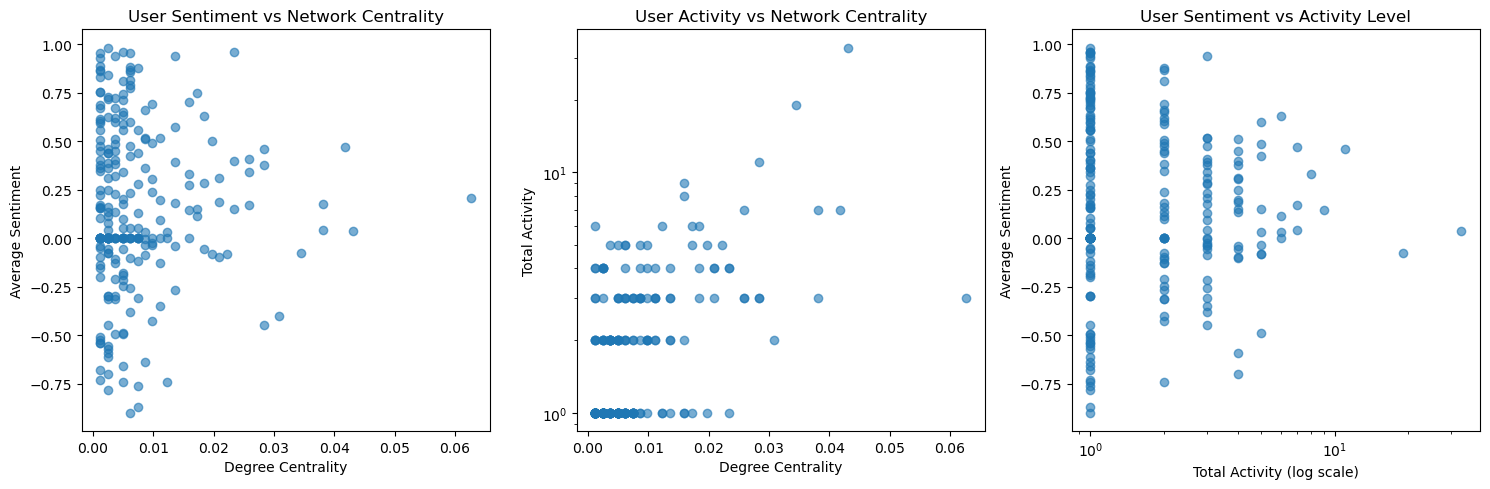


Top Influential Users Analysis:
                     sentiment_post  score_post  post_count  sentiment_comment  score_comment  comment_count  avg_sentiment  total_activity  degree_centrality
Economy_Square_1452          0.9744  229.000000         1.0          -0.179350      42.500000            2.0       0.205233             3.0           0.062731
wongm                        0.0000  155.333333         3.0           0.042880       5.266667           30.0       0.038982            33.0           0.043050
PolygonTransit               0.0000  255.000000         1.0           0.546783      17.500000            6.0       0.468671             7.0           0.041820
Johntrampoline-              0.0000    0.000000         0.0           0.175567       3.666667            3.0       0.175567             3.0           0.038130
Blue_Pie_Ninja               0.0000    0.000000         0.0           0.040486       6.285714            7.0       0.040486             7.0           0.038130
Ok-Foot6064  

In [95]:
# 7. Advanced Network-Sentiment Analysis 

def network_sentiment_analysis(graph, posts, comments):
    """Combine network and sentiment analysis with guaranteed proper syntax"""
    # Create user sentiment profiles
    user_comments = comments.groupby('author').agg({
        'sentiment': 'mean',
        'score': 'mean',
        'text': 'count'
    }).rename(columns={'text': 'comment_count'})
    
    user_posts = posts.groupby('author').agg({
        'sentiment': 'mean',
        'score': 'mean',
        'title': 'count'
    }).rename(columns={'title': 'post_count'})
    
    # Combine user data with outer join
    user_data = user_posts.join(user_comments, how='outer', lsuffix='_post', rsuffix='_comment')
    user_data = user_data.fillna(0)
    
    # Calculate combined metrics - COMPLETELY REWRITTEN FOR SAFETY
    total_posts_comments = (user_data['post_count'] + user_data['comment_count']).replace(0, 1)
    weighted_sentiment = (
        (user_data['sentiment_post'] * user_data['post_count']) + 
        (user_data['sentiment_comment'] * user_data['comment_count'])
    )
    user_data['avg_sentiment'] = weighted_sentiment / total_posts_comments
    user_data['total_activity'] = user_data['post_count'] + user_data['comment_count']
    
    # Get centrality measures
    centrality = pd.DataFrame.from_dict(
        nx.degree_centrality(graph),
        orient='index',
        columns=['degree_centrality']
    )
    
    # Join with network data
    user_data = user_data.join(centrality, how='inner')
    
    # Filter active users
    user_data = user_data[user_data['total_activity'] > 0]
    
    # Create visualizations
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Sentiment vs Centrality
    plt.subplot(1, 3, 1)
    plt.scatter(
        x=user_data['degree_centrality'],
        y=user_data['avg_sentiment'],
        alpha=0.6
    )
    plt.title('User Sentiment vs Network Centrality')
    plt.xlabel('Degree Centrality')
    plt.ylabel('Average Sentiment')
    
    # Plot 2: Activity vs Centrality
    plt.subplot(1, 3, 2)
    plt.scatter(
        x=user_data['degree_centrality'],
        y=user_data['total_activity'],
        alpha=0.6
    )
    plt.title('User Activity vs Network Centrality')
    plt.xlabel('Degree Centrality')
    plt.ylabel('Total Activity')
    plt.yscale('log')
    
    # Plot 3: Sentiment vs Activity
    plt.subplot(1, 3, 3)
    plt.scatter(
        x=user_data['total_activity'],
        y=user_data['avg_sentiment'],
        alpha=0.6
    )
    plt.title('User Sentiment vs Activity Level')
    plt.xlabel('Total Activity (log scale)')
    plt.ylabel('Average Sentiment')
    plt.xscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Identify key influencers
    influential_users = user_data[
        user_data['degree_centrality'] > user_data['degree_centrality'].quantile(0.9)
    ].sort_values('degree_centrality', ascending=False)
    
    print("\nTop Influential Users Analysis:")
    print(influential_users.head(10).to_string())
    
    return user_data

# Execute the analysis
try:
    user_analysis_df = network_sentiment_analysis(G, posts_df, comments_df)
except Exception as e:
    print(f"Analysis failed: {str(e)}")
    print("Please check:")
    print("1. Graph exists and has nodes")
    print("2. Posts and comments DataFrames are properly loaded")
    print("3. All required columns exist in the data")

In [101]:
## Enhanced Network Analysis with Rate Limit Handling

def build_transport_networks(posts_df, comments_df):
    """Build networks with comprehensive error handling"""
    
    def classify_transport(text):
        text = str(text).lower()
        vline_terms = ['vline', 'regional train', 'country train']
        metro_terms = ['metro', 'metro train', 'suburban train']
        is_vline = any(term in text for term in vline_terms)
        is_metro = any(term in text for term in metro_terms)
        return 'vline' if is_vline and not is_metro else 'metro' if is_metro and not is_vline else 'other'

    # Classify content
    posts_df['transport_type'] = posts_df['clean_text'].apply(classify_transport)
    comments_df['transport_type'] = comments_df['clean_text'].apply(classify_transport)

    networks = {
        'vline': {'user_net': nx.DiGraph(), 'discussion_net': nx.Graph()},
        'metro': {'user_net': nx.DiGraph(), 'discussion_net': nx.Graph()}
    }

    for transport in ['vline', 'metro']:
        print(f"\nBuilding {transport} networks...")
        transport_posts = posts_df[posts_df['transport_type'] == transport]
        post_ids = set(transport_posts['id'])
        
        transport_comments = comments_df[
            (comments_df['transport_type'] == transport) | 
            (comments_df['post_id'].isin(post_ids))
        ]

        user_interactions = {}
        discussion_edges = set()
        processed = 0
        rate_limit_wait = 5  # Initial wait time in seconds

        for post_id in transport_posts['id'].unique()[:150]:  # Reduced limit for safety
            while True:  # Retry loop for rate limits
                try:
                    submission = reddit.submission(id=post_id)
                    submission.comments.replace_more(limit=2)  # Reduced comment depth
                    
                    for comment in submission.comments.list():
                        # User interactions
                        if comment.author and comment.parent_id.startswith('t1_'):
                            try:
                                parent = reddit.comment(id=comment.parent_id[3:])
                                if parent.author:
                                    edge = (str(comment.author), str(parent.author))
                                    user_interactions[edge] = user_interactions.get(edge, 0) + 1
                            except Exception as e:
                                print(f"Error processing parent comment: {e}")
                                continue
                        
                        # Discussion edges
                        if comment.author:
                            discussion_edges.add((comment.id, post_id))
                            if comment.parent_id.startswith('t1_'):
                                discussion_edges.add((comment.id, comment.parent_id[3:]))
                    
                    processed += 1
                    if processed % 10 == 0:
                        print(f"Processed {processed} posts")
                    time.sleep(1)  # Basic rate limiting
                    break  # Success - exit retry loop
                
                except Exception as e:
                    if '429' in str(e):
                        print(f"Rate limited. Waiting {rate_limit_wait} seconds...")
                        time.sleep(rate_limit_wait)
                        rate_limit_wait *= 2  # Exponential backoff
                        if rate_limit_wait > 60:
                            print("Waiting 1 minute before continuing...")
                            time.sleep(60)
                            rate_limit_wait = 5
                    else:
                        print(f"Error processing post {post_id}: {e}")
                        break  # Non-rate-limit error

        # Build networks after collection
        for (source, target), weight in user_interactions.items():
            networks[transport]['user_net'].add_edge(source, target, weight=weight)
        
        for source, target in discussion_edges:
            networks[transport]['discussion_net'].add_edge(source, target)
        
        print(f"\n{transport.upper()} Network Summary:")
        print(f"- Users: {networks[transport]['user_net'].number_of_nodes()}")
        print(f"- Interactions: {networks[transport]['user_net'].number_of_edges()}")
        print(f"- Discussion Nodes: {networks[transport]['discussion_net'].number_of_nodes()}")
        print(f"- Discussion Edges: {networks[transport]['discussion_net'].number_of_edges()}")
    
    return networks

In [103]:
# Build networks with error handling
print("Starting network construction...")
start_time = time.time()

try:
    transport_networks = build_transport_networks(posts_df, comments_df)
    print(f"\nNetwork construction completed in {time.time()-start_time:.2f} seconds")
except Exception as e:
    print(f"Fatal error during network construction: {e}")
    print("Partial results may be available in transport_networks variable")

Starting network construction...

Building vline networks...
Error processing parent comment: received 429 HTTP response
Processed 10 posts
Processed 20 posts
Processed 30 posts
Processed 40 posts

VLINE Network Summary:
- Users: 250
- Interactions: 421
- Discussion Nodes: 953
- Discussion Edges: 1462

Building metro networks...
Processed 10 posts
Error processing parent comment: received 429 HTTP response
Error processing parent comment: received 429 HTTP response
Processed 20 posts
Processed 30 posts
Processed 40 posts

METRO Network Summary:
- Users: 564
- Interactions: 901
- Discussion Nodes: 1941
- Discussion Edges: 2953

Network construction completed in 1041.29 seconds


In [104]:
## Visualization with Fallback Options

def safe_visualize(networks, transport):
    """Visualization with automatic fallbacks"""
    try:
        user_net = networks[transport]['user_net']
        if user_net.number_of_nodes() == 0:
            print(f"No user network data for {transport}")
            return
        
        print(f"\nVisualizing {transport} networks...")
        
        # User Network Visualization
        plt.figure(figsize=(10, 8))
        try:
            pos = nx.spring_layout(user_net, k=0.15, iterations=20)
        except:
            pos = nx.random_layout(user_net)
            
        nx.draw_networkx_nodes(user_net, pos, node_size=30, alpha=0.6)
        nx.draw_networkx_edges(user_net, pos, width=0.5, alpha=0.2)
        plt.title(f"{transport.upper()} User Interaction Network")
        plt.show()
        
        # Discussion Network Visualization (Largest Component)
        disc_net = networks[transport]['discussion_net']
        if disc_net.number_of_nodes() > 1:
            try:
                largest_cc = max(nx.connected_components(disc_net), key=len)
                subgraph = disc_net.subgraph(largest_cc)
                
                plt.figure(figsize=(12, 10))
                try:
                    pos = nx.kamada_kawai_layout(subgraph)
                except:
                    pos = nx.spring_layout(subgraph, k=0.1)
                    
                nx.draw_networkx_nodes(subgraph, pos, node_size=20, alpha=0.6)
                nx.draw_networkx_edges(subgraph, pos, width=0.3, alpha=0.1)
                plt.title(f"{transport.upper()} Discussion Network (Largest Component)")
                plt.show()
                
            except Exception as e:
                print(f"Error visualizing discussion network: {e}")
    
    except Exception as e:
        print(f"Visualization failed: {e}")



Visualizing vline networks...


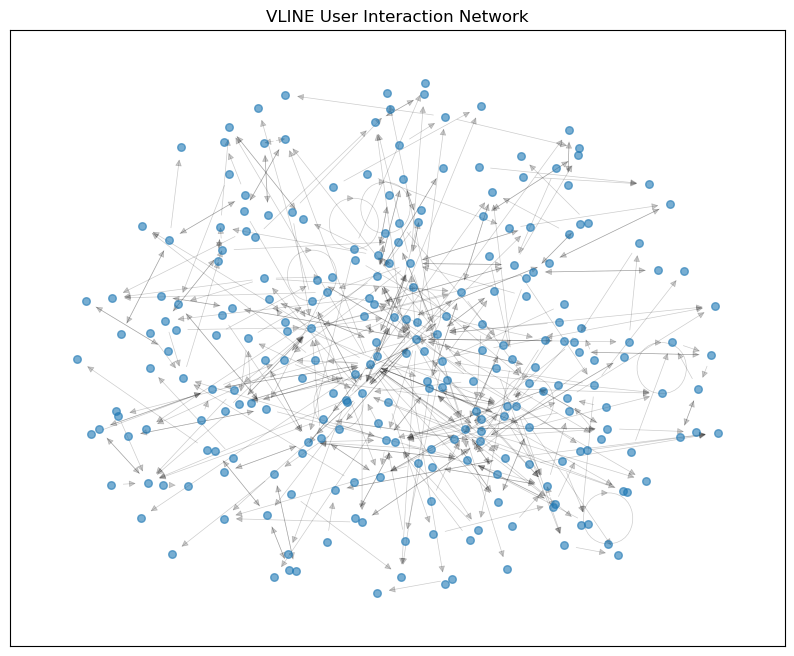

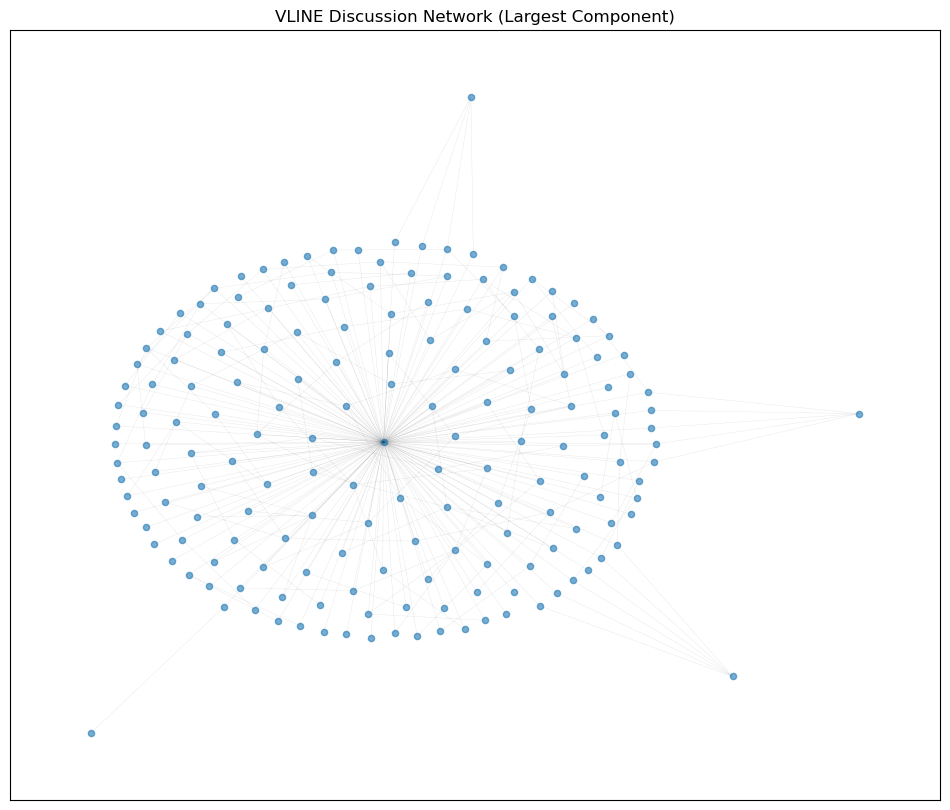


Visualizing metro networks...


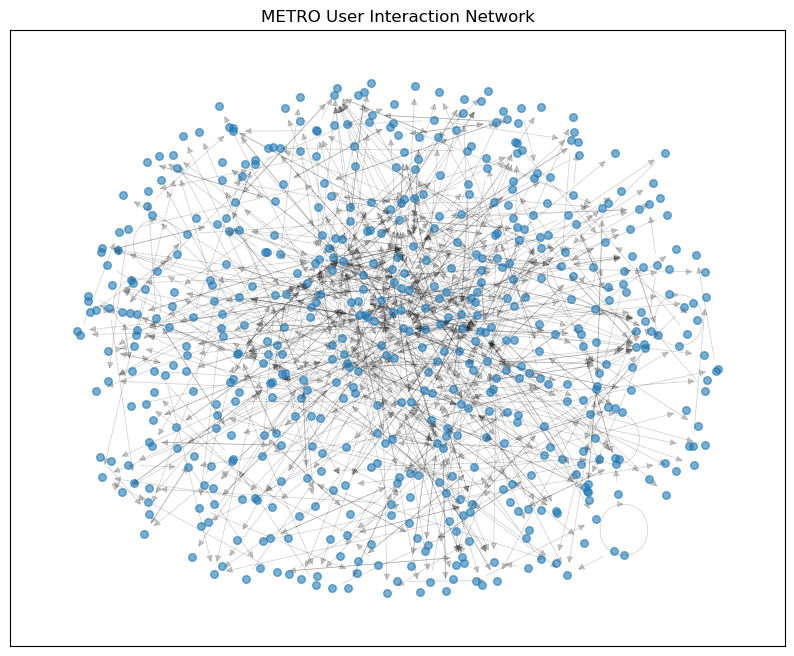

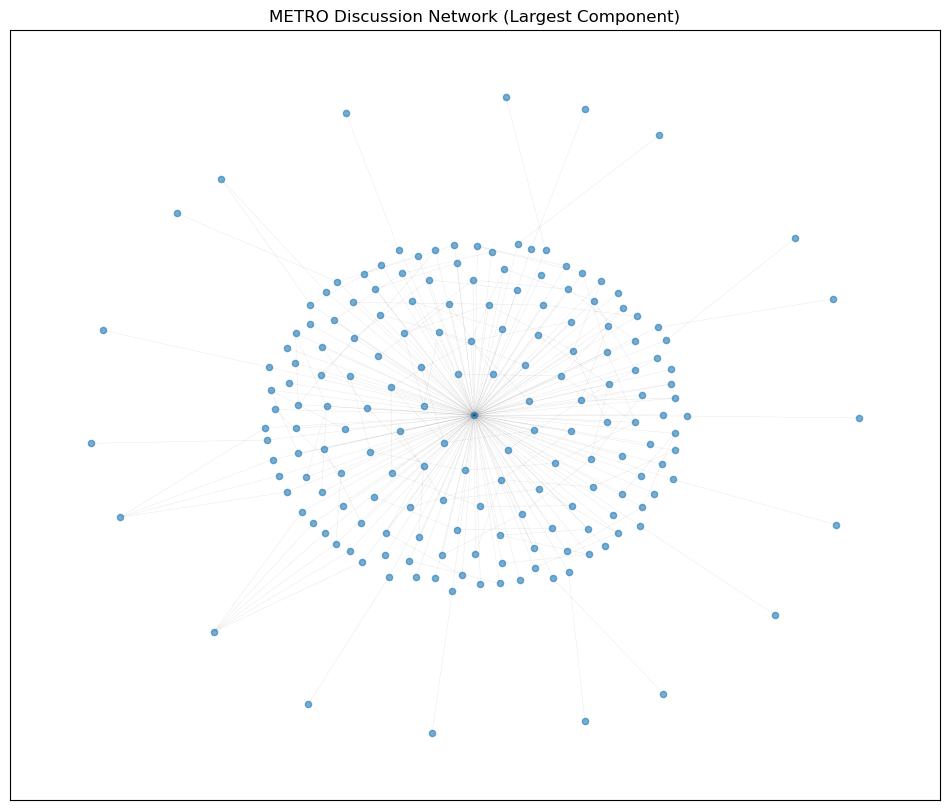

In [105]:
# Generate visualizations
for transport in ['vline', 'metro']:
    safe_visualize(transport_networks, transport)


In [106]:
## Network Metrics Export

def save_network_data(networks):
    """Save network data for external analysis"""
    for transport in ['vline', 'metro']:
        # Save user network
        nx.write_gexf(networks[transport]['user_net'], f"{transport}_user_network.gexf")
        
        # Save discussion network
        nx.write_gexf(networks[transport]['discussion_net'], f"{transport}_discussion_network.gexf")
        
        # Save edge lists
        nx.write_edgelist(networks[transport]['user_net'], f"{transport}_user_edgelist.txt")
        nx.write_edgelist(networks[transport]['discussion_net'], f"{transport}_discussion_edgelist.txt")
    
    print("Network data saved in GEXF and edge list formats")

save_network_data(transport_networks)

Network data saved in GEXF and edge list formats


In [ ]:
#Visualization and Analysis

def analyze_and_visualize(networks):
    """Analyze and visualize the transport networks"""
    
    for transport in ['vline', 'metro']:
        print(f"\n===== {transport.upper()} ANALYSIS =====")
        
        # User Interaction Network Analysis
        user_net = networks[transport]['user_net']
        if user_net.number_of_nodes() > 0:
            print("\nUser Interaction Network:")
            print(f"- Density: {nx.density(user_net):.4f}")
            print(f"- Average Clustering: {nx.average_clustering(user_net.to_undirected()):.4f}")
            
            # Centrality measures
            degree_cent = nx.degree_centrality(user_net)
            top_users = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:5]
            print("Top Central Users:")
            for user, score in top_users:
                print(f"  {user}: {score:.3f}")
            
            # Visualization
            plt.figure(figsize=(10, 8))
            pos = nx.spring_layout(user_net, k=0.3)
            nx.draw_networkx(
                user_net, pos, 
                with_labels=False,
                node_size=50,
                width=0.2,
                edge_color='gray',
                alpha=0.7
            )
            plt.title(f"{transport.upper()} User Interaction Network")
            plt.show()
        
        # Discussion Network Analysis
        disc_net = networks[transport]['discussion_net']
        if disc_net.number_of_nodes() > 0:
            print("\nDiscussion Network:")
            print(f"- Connected Components: {nx.number_connected_components(disc_net)}")
            
            # Largest component analysis
            largest_cc = max(nx.connected_components(disc_net), key=len)
            subgraph = disc_net.subgraph(largest_cc)
            print(f"- Largest Component: {len(largest_cc)} nodes")
            print(f"- Diameter: {nx.diameter(subgraph)}")
            
            # Visualization
            plt.figure(figsize=(12, 10))
            pos = nx.kamada_kawai_layout(subgraph)
            nx.draw_networkx(
                subgraph, pos,
                with_labels=False,
                node_size=20,
                alpha=0.6,
                edge_color='lightblue'
            )
            plt.title(f"{transport.upper()} Discussion Network (Largest Component)")
            plt.show()

# Run analysis and visualization
analyze_and_visualize(transport_networks)


Comparative Network Metrics:
                          vline        metro
user_nodes           250.000000   564.000000
user_edges           421.000000   901.000000
user_density           0.006763     0.002838
discussion_nodes     953.000000  1941.000000
discussion_edges    1462.000000  2953.000000
largest_component    173.000000   184.000000
component_density      0.020433     0.016987
user_engagement        1.684000     1.597518
discussion_breadth     1.534103     1.521381


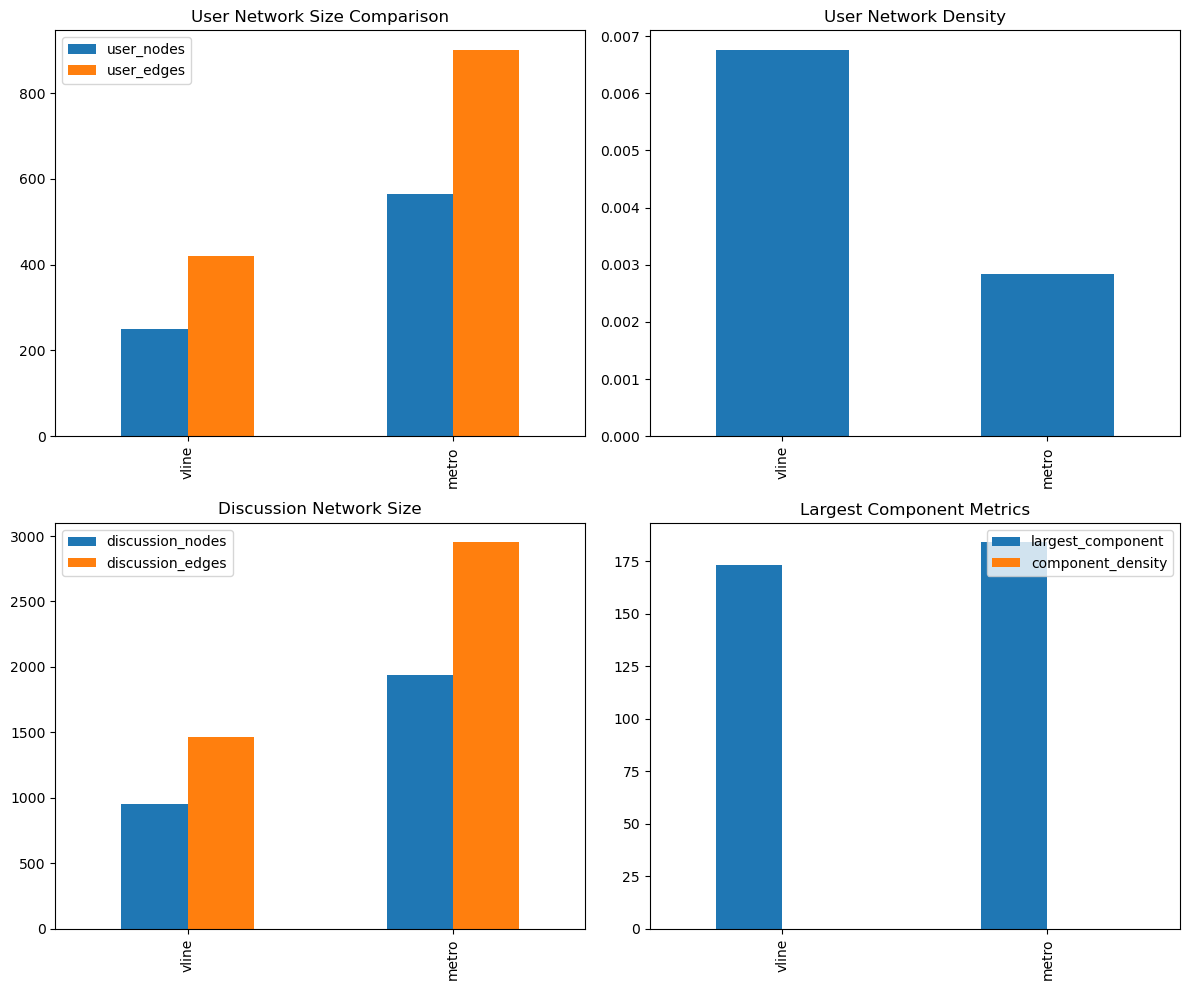

In [107]:
# Comparative Metrics

def compare_networks(networks):
    """Generate comparative metrics between V/Line and Metro networks"""
    
    comparison = pd.DataFrame(index=['vline', 'metro'])
    
    for transport in ['vline', 'metro']:
        user_net = networks[transport]['user_net']
        disc_net = networks[transport]['discussion_net']
        
        # User network metrics
        comparison.loc[transport, 'user_nodes'] = user_net.number_of_nodes()
        comparison.loc[transport, 'user_edges'] = user_net.number_of_edges()
        comparison.loc[transport, 'user_density'] = nx.density(user_net)
        
        # Discussion network metrics
        comparison.loc[transport, 'discussion_nodes'] = disc_net.number_of_nodes()
        comparison.loc[transport, 'discussion_edges'] = disc_net.number_of_edges()
        
        # Largest component stats
        if disc_net.number_of_nodes() > 0:
            largest_cc = max(nx.connected_components(disc_net), key=len)
            subgraph = disc_net.subgraph(largest_cc)
            comparison.loc[transport, 'largest_component'] = len(largest_cc)
            comparison.loc[transport, 'component_density'] = nx.density(subgraph)
    
    # Calculate ratios
    comparison['user_engagement'] = comparison['user_edges'] / comparison['user_nodes']
    comparison['discussion_breadth'] = comparison['discussion_edges'] / comparison['discussion_nodes']
    
    print("\nComparative Network Metrics:")
    print(comparison.T)
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # User network comparison
    comparison[['user_nodes', 'user_edges']].plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('User Network Size Comparison')
    
    comparison['user_density'].plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title('User Network Density')
    
    # Discussion network comparison
    comparison[['discussion_nodes', 'discussion_edges']].plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Discussion Network Size')
    
    comparison[['largest_component', 'component_density']].plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Largest Component Metrics')
    
    plt.tight_layout()
    plt.show()

compare_networks(transport_networks)